# Set up the environment

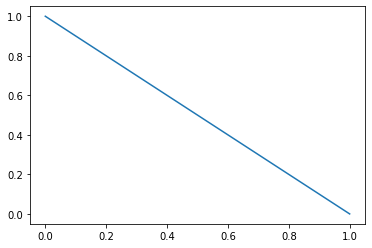

INFO:root:test
INFO:root:test


(-75, -56)
Import of badexp.ADEXPBackend failed due to:
No module named 'neuronunit.models.backends.badexp'
Import of bhh.BHHBackend failed due to:
No module named 'neuronunit.models.backends.bhh'
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.plot([0,1],[1,0])
plt.show()
import hide_imports
from neuronunit.optimisation.optimization_management import inject_and_plot_model


# Design simulated data tests

In [2]:
def jrt(use_test,backend):
    use_test = hide_imports.TSD(use_test)
    use_test.use_rheobase_score = True
    edges = hide_imports.model_parameters.MODEL_PARAMS[backend]

    OM = hide_imports.OptMan(use_test,\
                backend=backend,\
                boundary_dict=edges,\
                protocol={'allen': False, 'elephant': True})

    return OM



In [3]:
test_frame = hide_imports.get_neab.process_all_cells()
test_frame.pop('Olfactory bulb (main) mitral cell',None)
stds = {}
for k,v in hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6']).items():
    temp = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])[k]
    stds[k] = temp.observation['std']
    print((temp.name,temp.observation))
OMObjects = []
backends = ["RAW"]
import copy
cloned_tests = copy.copy(test_frame['Neocortex pyramidal cell layer 5-6'])
import copy
for b in backends:        
    OM = jrt(cloned_tests,b)
    OMObjects.append(OM)
rt_outs = []

('RheobaseTest', {'mean': array(213.84958333) * pA, 'std': array(170.45245472) * pA, 'n': 32})
('InputResistanceTest', {'mean': array(120.67207364) * Mohm, 'std': array(77.63316083) * Mohm, 'n': 86})
('TimeConstantTest', {'mean': array(15.73424242) * ms, 'std': array(7.31162637) * ms, 'n': 33})
('CapacitanceTest', {'mean': array(150.58416667) * pF, 'std': array(139.68388463) * pF, 'n': 12})
('RestingPotentialTest', {'mean': array(-68.24814346) * mV, 'std': array(6.53234788) * mV, 'n': 79})
('InjectedCurrentAPWidthTest', {'mean': array(1.20769388) * ms, 'std': array(0.53434592) * ms, 'n': 49})
('InjectedCurrentAPAmplitudeTest', {'mean': array(80.43510204) * mV, 'std': array(12.74880304) * mV, 'n': 49})
('InjectedCurrentAPThresholdTest', {'mean': array(-42.73572327) * mV, 'std': array(8.04073233) * mV, 'n': 53})


In [4]:
for OM in OMObjects:
   print(OM.backend)
   x= {k:v for k,v in OM.tests.items() if 'mean' in v.observation.keys() or 'value' in v.observation.keys()}
   cloned_tests = copy.copy(OM.tests)
   OM.tests = hide_imports.TSD(cloned_tests)
   rt_out = OM.simulate_data(OM.tests,OM.backend,OM.boundary_dict)
   #print(rt_out)


RAW
RheobaseTest
{'value': array(43.71500015) * pA} is this called?
InputResistanceTest
{'value': array(67054527.39206876) * kg*m**2/(s**3*A**2)} is this called?
TimeConstantTest
{'value': array(4.20389353) * ms} is this called?
CapacitanceTest
{'value': array(6.26936568e-11) * s**4*A**2/(kg*m**2)} is this called?
RestingPotentialTest
{'mean': array(-57.92515332) * mV, 'std': array(4.26325641e-14) * mV} is this called?
InjectedCurrentAPWidthTest
{'mean': array(0.00052) * s, 'std': array(0.) * s, 'n': 1} is this called?
InjectedCurrentAPAmplitudeTest
{'value': array(46.65250863) * mV, 'mean': array(46.65250863) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
InjectedCurrentAPThresholdTest
{'mean': array(-25.54106671) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
Random simulated data tests made


In [5]:
penultimate_tests = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])
for k,v in penultimate_tests.items():
    temp = penultimate_tests[k]

    v = rt_out[1][k].observation
    v['std'] = stds[k]
simulated_data_tests = hide_imports.TSD(penultimate_tests)

# Show what the randomly generated target waveform the optimizer needs to find actually looks like

(AnalogSignal with 1 channels of length 130000; units mV; datatype float64 
 sampling rate: 100.0
 time: 0.0 to 1.3,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>)

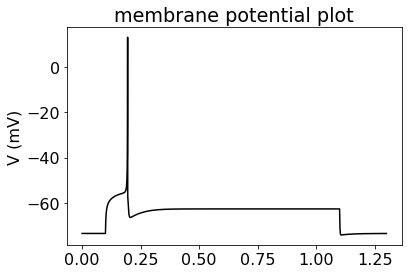

In [6]:
target = rt_out[0]
target.rheobase
inject_and_plot_model(target)

# Commence optimization of models on simulated data sets

# first lets just optimize over single objective functions at a time.

In [7]:
ga_out_rh = hide_imports.TSD([simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_rh = ga_out_rh['pf'][0].dtc
opt_rh.obs_preds

,RheobaseTest,total
observations,43.71500015258789 pA,NaN
predictions,43.61423850059509 pA,NaN
scores,0.000471775,0.000472


In [8]:
ga_out_time = hide_imports.TSD([simulated_data_tests["TimeConstantTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_time = ga_out_time['pf'][0].dtc
opt_time.obs_preds

,TimeConstantTest,total
observations,4.203893528912502 ms,NaN
predictions,4.2017992482721045 ms,NaN
scores,0.000228565,0.000229


In [9]:
both = hide_imports.TSD([simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=20,NGEN=5)
both = both['pf'][0].dtc
both.obs_preds

,TimeConstantTest,RheobaseTest,total
observations,4.203893528912502 ms,43.71500015258789 pA,NaN
predictions,4.220255470140051 ms,37.503379583358765 pA,NaN
scores,0.0017871,0.0295009,0.031288


In [10]:
three = hide_imports.TSD([simulated_data_tests["InjectedCurrentAPWidthTest"],simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=6)


In [11]:
three = three['pf'][0].dtc
three.obs_preds

,InjectedCurrentAPWidthTest,TimeConstantTest,RheobaseTest,total
observations,0.0005200000000000001 s,4.203893528912502 ms,43.71500015258789 pA,NaN
predictions,0.0006100000000000001 s,4.237358945916159 ms,40.50257205963135 pA,NaN
scores,0.143588,0.0036586,0.0151506,0.162397



# What have we learned? 
* It seems like for this neural model optimization problem, bigger population size is more useful than large MU.
* This probably comes down to our design choices. If the genes initially sample a large amount of the hypervolume, it takes a long time for the genes to be motivated explore unsampled regions, so its best to make the initial exploration a widely spanned sampling of all the dimensions a large population size ensures this.


# Now lets test all the objectives together?


In [12]:
ga_out = simulated_data_tests.optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=15)
opt = ga_out['pf'][0].dtc

In [13]:
front = [ind.dtc for ind in ga_out['pf']]

In [14]:
opt.rheobase


array(38.88579011) * pA

(AnalogSignal with 1 channels of length 130000; units mV; datatype float64 
 sampling rate: 100.0
 time: 0.0 to 1.3,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>)

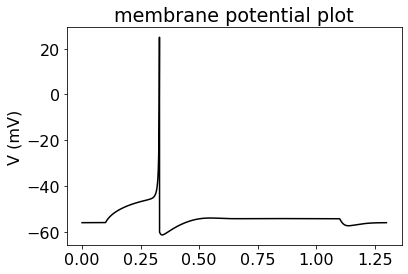

In [15]:
inject_and_plot_model(opt)

In [16]:
opt.obs_preds

,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,43.71500015258789 pA,67054527.39206876 kg*m**2/(s**3*A**2),4.203893528912502 ms,6.269365682547097e-11 s**4*A**2/(kg*m**2),-57.92515332029752 mV,0.0005200000000000001 s,46.65250863130824 mV,-25.541066705576764 mV,NaN
predictions,38.8857901096344 pA,39629001.78554065 kg*m**2/(s**3*A**2),3.984561882798394 ms,1.0054661241182799e-10 s**4*A**2/(kg*m**2),-56.0 mV,0.0007400000000000001 s,48.54174063187169 mV,-23.541740631871694 mV,NaN
scores,0.0228618,0.323122,0.0242221,0.240291,0.263686,0.38486,0.125344,0.218614,1.603001


In [17]:
model = opt.dtc_to_model()
score = simulated_data_tests['TimeConstantTest'].judge(model)
pred = simulated_data_tests['TimeConstantTest'].prediction
print(pred)

{'value': array(3.98456188) * ms}


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

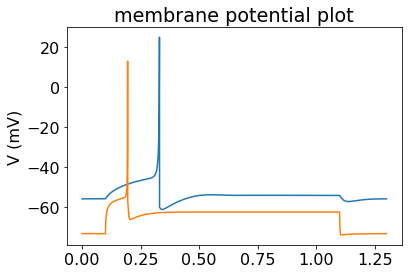

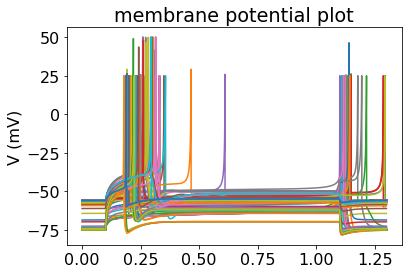

In [18]:
from neuronunit.optimisation.optimization_management import check_binary_match, check_match_front
check_binary_match(opt,target)
check_match_front(target,front)


# Interpretation
Looking above at the observation/prediction table. The agreement is starting to look good for many tests
but the waveform matching is still bad. Perhaps the optimizer just needs more computation.
Fortunately its possible to seed 

In [ ]:
ga_revised = simulated_data_tests.optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=10,seed_pop=ga_out['pf'][0:24])
ga_revised = ga_out['pf'][0].dtc

In [ ]:
opt = ga_revised['pf'][0].dtc

##### 